<a href="https://colab.research.google.com/github/janah243/chatbot/blob/master/RoboJackets_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch 1.2 Quickstart with Google Colab
In this code tutorial we will learn how to quickly train a model to understand some of PyTorch's basic building blocks to train a deep learning model. This notebook is inspired by the ["Tensorflow 2.0 Quickstart for experts"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) notebook. 

After completion of this tutorial, you should be able to import data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for image classification.

**Author:** [Elvis Saravia](https://twitter.com/omarsar0)

**Unimportant Edits:** Jason Gibson

**Complete Code Walkthrough:** [Blog post](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)

Code was liberally taken from the above source. The goal was to minimize detail, please see the full tutorial for a more detailed look at nearly identical code.


In [ ]:
!pip3 install pillow torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 640.6MB 28kB/s 
     |████████████████████████████████| 4.0MB 26.4MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


Note: We will be using the latest stable version of PyTorch so be sure to run the command above to install the latest version of PyTorch, which as the time of this tutorial was 1.2.0. We PyTorch belowing using the `torch` module. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.4.0+cu92


## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

This section loads the dataset. We will also be using a different dataset of MNIST later on. This is the block where the change should be made.

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order. 

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

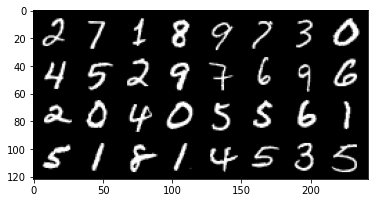

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

**EXERCISE:** Try to understand what the code above is doing. This will help you to better understand your dataset before moving forward. 

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. Here the model is constructed. This will not be changed in the project for today.

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

Here we will setup some useful functions that we will use later for visualizations.

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def insepct_detection(image, output):
    fig, axs = plt.subplots(2)
    fig.suptitle('Plots')
    axs[0].set_title("Image")
    image = np.transpose(image.numpy(), (1,2,0))
    axs[0].imshow(image)
    axs[1].bar(range(0,10), sample_output)
    axs[1].legend(loc='upper right', frameon=False)
    axs[1].set_title("Probability of digit")
    plt.show()

## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. This is where you will change the learning rate and the number of epochs to be completed.

In [ ]:
learning_rate = 1e-5 # <=================== CHANGE ME HERE
num_epochs = 3       # <=================== CHANGE ME HERE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now it's time for training. This code will output a histrogram with the probability of the given input image being each digit. It will output an image on the initial network (which is random). You should see essentially equal probabilities for each digit with random values and an initial accuracy of around 10% (1/10). After the first round of training there will be another image of the same digit and corresponding histogram. On the last error check it will output the final result of that image. There should be a clear answer to what digit the image is. After each epoch it will print out the accuracy on the test set and some statistics about the training.

No handles with labels found to put in legend.


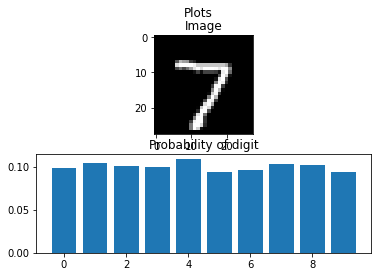

Initial Test Accuracy: 9.20
Epoch: 0 | Loss: 1.8515 | Train Accuracy: 73.64


No handles with labels found to put in legend.


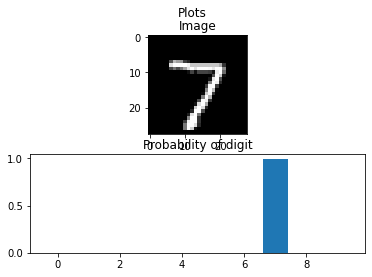

Test Accuracy: 89.75
Epoch: 1 | Loss: 1.6130 | Train Accuracy: 89.95
Test Accuracy: 91.68
Epoch: 2 | Loss: 1.5759 | Train Accuracy: 91.46


No handles with labels found to put in legend.


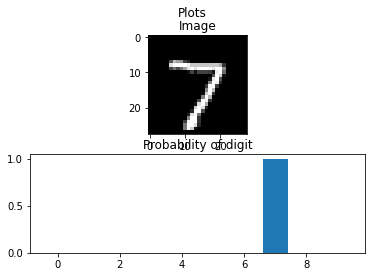

Test Accuracy: 92.51


In [ ]:
training_loss_plot = []
training_accuracy_plot = []
test_accuracy_plot = []

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    if i == 0:
        image = torchvision.utils.make_grid(images.cpu()[0])
        sample_output = outputs[0].cpu().detach().numpy()
        insepct_detection(image, sample_output)


print('Initial Test Accuracy: %.2f'%( test_acc/i))

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    average_train_loss = train_running_loss / i
    average_train_accuracy = train_acc / i
    training_loss_plot.append(100 - average_train_loss)
    training_accuracy_plot.append(100 - average_train_accuracy)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, average_train_loss, average_train_accuracy))


    test_acc = 0.0
    for i, (images, labels) in enumerate(testloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        # only show result on the last epoch
        if i == 0 and (epoch+1 is num_epochs or epoch == 0):
            image = torchvision.utils.make_grid(images.cpu()[0])
            sample_output = outputs[0].cpu().detach().numpy()
            insepct_detection(image, sample_output)
    test_accuracy_plot.append(100 - test_acc/i)
    print('Test Accuracy: %.2f'%( test_acc/i))      

Use the following section of code to visualize some nice plots of the data. This will output the error curves for the above training.

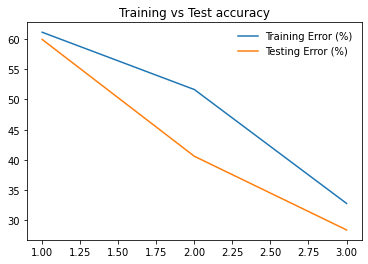

In [ ]:
plt.title("Training vs Test accuracy")
plt.plot(range(1,num_epochs+1), training_accuracy_plot, label='Training Error (%)')
plt.plot(range(1,num_epochs+1), test_accuracy_plot, label='Testing Error (%)')
plt.legend(loc='upper right', frameon=False)
plt.show()

Thanks for following along with this tutorial. The Markdown file should have more detailed explanations of what you should be doing for this project. As usual this is the first time we have done something like this and I would love to know of ways to improve it. Feel free to email me directly (jgibson37@gatech.edu) or reach out through whatever means you can.


## Final Words From The Original Author
That's it for this tutorial! Congratulations! You are now able to implement a basic CNN model in PyTorch for image classification. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling, but as you saw, you don't really need it here as results look good. If you are interested in implementing a similar image classification model using RNNs see the references below. 

## References
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) 